## Strategy

1) We will set a constant minimum daily rate (base_price) for up to 6 guests.

2) Every additional guest or pet will pay a constant price.

3) We will use a combination of the following functions to predict the pricing:
* Average Daily Rate (adr)
* Holidays in Peru (seasonality)
* Weekend premium
* Booking time in advance

4) As KPIs to measure success, we will monitor
* our weekly income to the Target weekly RevPAR

5) As monitored KPIs for potential future analysis, we will monitor:
* Occupancy rate

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import mplcursors

In [2]:
#ipympl enables 'matplotlib widget' for interactive widgets framework
%matplotlib widget

## Chaclacayo

In [3]:
# Prices in PEN (Peruvial Soles), daily rate
base_price = 350
extra_guest = 50 
extra_pet = 50

In [4]:
# Import Airbnb RevPAR data of Chaclacayo - Peru
df_revPAR = pd.read_excel('seasonality.xlsx', sheet_name='RevPAR-Chaclacayo')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR
0,2021-09-01,1034,Wednesday,35,0.834881
1,2021-09-02,678,Thursday,35,0.467492
2,2021-09-03,838,Friday,35,0.632611
3,2021-09-04,884,Saturday,35,0.680083
4,2021-09-05,834,Sunday,35,0.628483


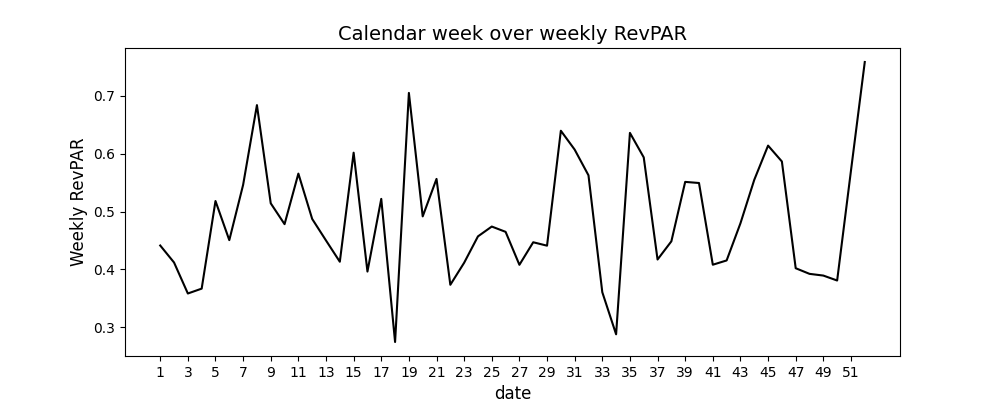

In [5]:
# Calculate aggregated RevPAR per Calendar Week
cw_df_revPAR = df_revPAR.groupby(df_revPAR.CW)['n_RevPAR'].sum()/7

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cw_df_revPAR, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Weekly RevPAR", color="black", fontsize=12)

temp = range(1,53,2);plt.xticks(temp);del temp
plt.title('Calendar week over weekly RevPAR', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [6]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
#df_holidays['Importance'] = 0.0
df_holidays.head()

,Date,Holiday,Importance,CW
0,2021-08-30,Santa Rosa de Lima,0.0,35
1,2021-10-08,Combate Naval de Angamos,0.0,40
2,2021-11-01,Día de todos los Santos,0.0,44
3,2021-12-08,Inmaculada Concepción,0.0,49
4,2021-12-25,Navidad,0.0,51


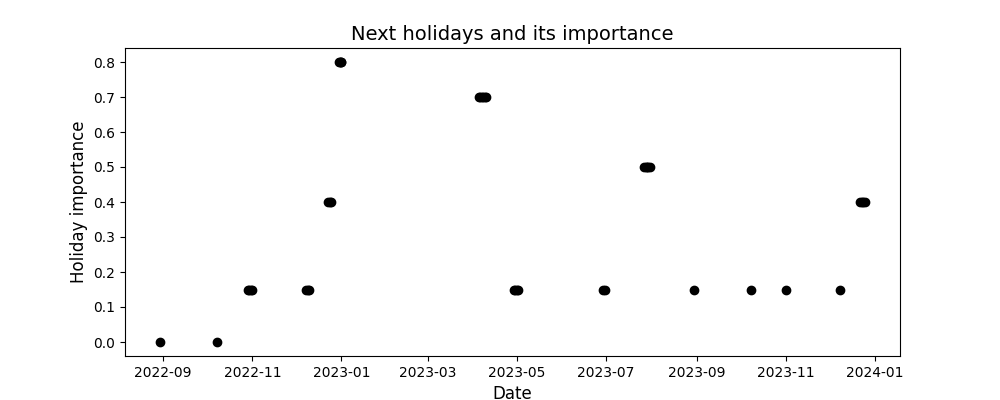

In [7]:
# Drop older holidays
df_holidays = df_holidays.drop(df_holidays[df_holidays.Date < '2022-08'].index)
df_holidays.reset_index(inplace=True)
df_holidays.drop(columns=['index'], inplace=True)

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(df_holidays['Date'], df_holidays['Importance'], color="black", label="n_RevPAR")
ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Holiday importance", color="black", fontsize=12)

plt.title('Next holidays and its importance', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [8]:
# Import Airbnb Booking Lead Time - BLT
df_BLT = pd.read_excel('seasonality.xlsx', sheet_name='BLT-Chaclacayo')
df_BLT.rename(columns={"Booking_Lead_Time (days)": "BLT_days"}, inplace=True)
df_BLT['btl_Month'] = pd.to_datetime(df_BLT['Month']).dt.month
df_BLT.sort_values('btl_Month', inplace=True)
df_BLT.reset_index(inplace=True)
df_BLT.head(12)

,index,Month,BLT_days,btl_Month
0,5,2022-01,15,1
1,6,2022-02,16,2
2,7,2022-03,11,3
3,8,2022-04,19,4
4,9,2022-05,14,5
5,10,2022-06,15,6
6,11,2022-07,26,7
7,0,2021-08,18,8
8,12,2022-08,13,8
9,1,2021-09,15,9


In [9]:
# We create the function that will predict the prices for up to 2023

df = pd.DataFrame(columns=['Date', 'CW', 'Price'])
df['Date'] = pd.date_range(date(2022,9,1),date(2023,9,1)-timedelta(days=1),freq='d') # <--- ANALYSIS TIME-FRAME
df['CW'] = df['Date'].dt.isocalendar().week

df['Price'] = base_price

for index, row in df.iterrows():   
    # Holiday effect - Special dates
    if not (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).empty:
        df.loc[index-1, 'Price'] = df.loc[index-1, 'Price'] + base_price * (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).iloc[0]
    # CW effect - Seasonality
    df.loc[index, 'Price'] = df.loc[index, 'Price'] + base_price * (cw_df_revPAR.iloc[row.CW-1]) *.5 # 0.5 to attenuate its effect
    
    # Weekend effect - 15% Premium
    if row.Date.day_name() == 'Friday' or row.Date.day_name() == 'Saturday':
        df.loc[index, 'Price'] = df.loc[index, 'Price'] * 1.1 # 10% in Chaclacayo y 20% en Pachacamac
    
    # Booking Lead Time discount
    #if (row.Date-pd.Timestamp.now()) < pd.Timedelta(10, "d"):
    #    df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    #    if (row.Date-pd.Timestamp.now()) < pd.Timedelta(5, "d"):
    #        df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    
    # Prevents dropping below base_price
    if df.loc[index, 'Price'] < base_price:
        df.loc[index, 'Price'] = base_price


        Date  CW       Price
0 2022-09-01  35  461.274510
1 2022-09-02  35  507.401961
2 2022-09-03  35  507.401961
3 2022-09-04  35  461.274510
4 2022-09-05  36  453.869969


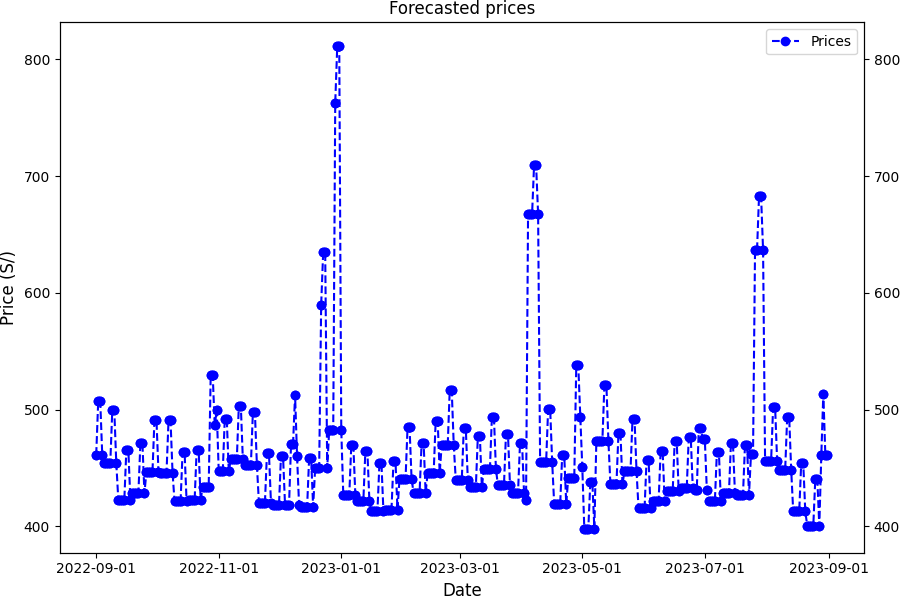

In [10]:
# Drop values too far into the future
df = df.drop(df[df.Date > '2023-09'].index)

print(df.head())
import matplotlib.dates as mdates

# We plot
fig, ax = plt.subplots(figsize=(9, 6))

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

ax.scatter(df['Date'], df['Price'], color="blue", label="Prices")
ax2=ax.twinx()
ax2.plot(df['Date'], df['Price'], '--o', color="blue", label="Prices")

ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Price (S/)", color="black", fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Forecasted prices', fontsize = 12)
plt.legend()
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)

mplcursors.cursor(ax,hover=True) # Interacive

plt.show()

In [11]:
for index, row in df.iterrows():   
    print(row.Date.strftime('%Y-%m-%d'), " ", round(row.Price))

2022-09-01   461
2022-09-02   507
2022-09-03   507
2022-09-04   461
2022-09-05   454
2022-09-06   454
2022-09-07   454
2022-09-08   454
2022-09-09   499
2022-09-10   499
2022-09-11   454
2022-09-12   423
2022-09-13   423
2022-09-14   423
2022-09-15   423
2022-09-16   465
2022-09-17   465
2022-09-18   423
2022-09-19   429
2022-09-20   429
2022-09-21   429
2022-09-22   429
2022-09-23   471
2022-09-24   471
2022-09-25   429
2022-09-26   446
2022-09-27   446
2022-09-28   446
2022-09-29   446
2022-09-30   491
2022-10-01   491
2022-10-02   446
2022-10-03   446
2022-10-04   446
2022-10-05   446
2022-10-06   446
2022-10-07   491
2022-10-08   491
2022-10-09   446
2022-10-10   421
2022-10-11   421
2022-10-12   421
2022-10-13   421
2022-10-14   464
2022-10-15   464
2022-10-16   421
2022-10-17   423
2022-10-18   423
2022-10-19   423
2022-10-20   423
2022-10-21   465
2022-10-22   465
2022-10-23   423
2022-10-24   434
2022-10-25   434
2022-10-26   434
2022-10-27   434
2022-10-28   530
2022-10-29   5

In [12]:
df.to_csv('Chaclacayo_prices.txt', columns=['Date','Price'], header=False, index=False, sep=' ', mode='w', float_format='%0.d')

## Pachacamac

In [13]:
# Prices in PEN (Peruvial Soles), daily rate
base_price = 350
extra_guest = 50 
extra_pet = 50

In [14]:
# Import Airbnb RevPAR data of Pachacamac - Peru
df_revPAR = pd.read_excel('seasonality.xlsx', sheet_name='RevPAR-Pachacamac')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR
0,2021-09-01,625,Wednesday,35,0.372996
1,2021-09-02,579,Thursday,35,0.334177
2,2021-09-03,703,Friday,35,0.438819
3,2021-09-04,745,Saturday,35,0.474262
4,2021-09-05,692,Sunday,35,0.429536


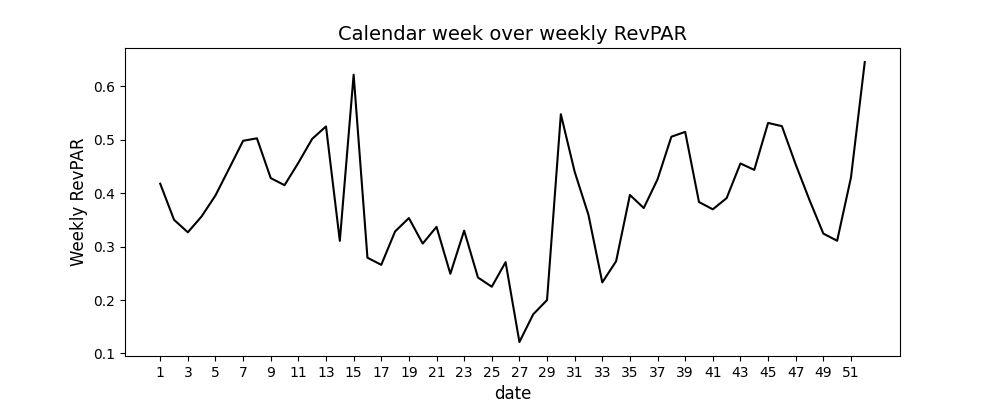

In [15]:
# Calculate aggregated RevPAR per Calendar Week
cw_df_revPAR = df_revPAR.groupby(df_revPAR.CW)['n_RevPAR'].sum()/7

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(cw_df_revPAR, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 12)
ax.set_ylabel("Weekly RevPAR", color="black", fontsize=12)

temp = range(1,53,2);plt.xticks(temp);del temp
plt.title('Calendar week over weekly RevPAR', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [16]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
#df_holidays['Importance'] = 0.0
df_holidays.head()

,Date,Holiday,Importance,CW
0,2021-08-30,Santa Rosa de Lima,0.0,35
1,2021-10-08,Combate Naval de Angamos,0.0,40
2,2021-11-01,Día de todos los Santos,0.0,44
3,2021-12-08,Inmaculada Concepción,0.0,49
4,2021-12-25,Navidad,0.0,51


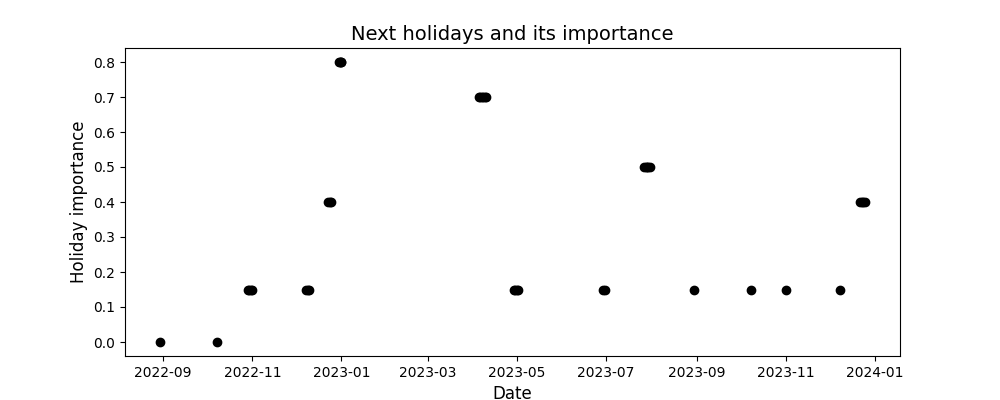

In [17]:
# Drop older holidays
df_holidays = df_holidays.drop(df_holidays[df_holidays.Date < '2022-08'].index)
df_holidays.reset_index(inplace=True)
df_holidays.drop(columns=['index'], inplace=True)

# We plot RevPAR
fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(df_holidays['Date'], df_holidays['Importance'], color="black", label="n_RevPAR")
ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Holiday importance", color="black", fontsize=12)

plt.title('Next holidays and its importance', fontsize = 14)

mplcursors.cursor(hover=True) # Interacive

plt.show()

In [18]:
# Import Airbnb Booking Lead Time - BLT
df_BLT = pd.read_excel('seasonality.xlsx', sheet_name='BLT-Pachacamac')
df_BLT.rename(columns={"Booking_Lead_Time (days)": "BLT_days"}, inplace=True)
df_BLT['btl_Month'] = pd.to_datetime(df_BLT['Month']).dt.month
df_BLT.sort_values('btl_Month', inplace=True)
df_BLT.reset_index(inplace=True)
df_BLT.head(12)

,index,Month,BLT_days,btl_Month
0,4,2022-01,27,1
1,5,2022-02,21,2
2,6,2022-03,30,3
3,7,2022-04,27,4
4,8,2022-05,20,5
5,9,2022-06,25,6
6,10,2022-07,23,7
7,11,2022-08,20,8
8,0,2021-09,17,9
9,1,2021-10,25,10


In [19]:
# We create the function that will predict the prices for up to 2023

df = pd.DataFrame(columns=['Date', 'CW', 'Price'])
df['Date'] = pd.date_range(date(2022,9,1),date(2023,9,1)-timedelta(days=1),freq='d') # <--- ANALYSIS TIME-FRAME
df['CW'] = df['Date'].dt.isocalendar().week

df['Price'] = base_price

for index, row in df.iterrows():   
    # Holiday effect - Special dates
    if not (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).empty:
        df.loc[index-1, 'Price'] = df.loc[index-1, 'Price'] + base_price * (df_holidays[df_holidays['Date']==row.Date.strftime('%Y-%m-%d')]['Importance']).iloc[0]
    # CW effect - Seasonality
    df.loc[index, 'Price'] = df.loc[index, 'Price'] + base_price * (cw_df_revPAR.iloc[row.CW-1]) *.5 # 0.5 to attenuate its effect
    
    # Weekend effect - 15% Premium
    if row.Date.day_name() == 'Friday' or row.Date.day_name() == 'Saturday':
        df.loc[index, 'Price'] = df.loc[index, 'Price'] * 1.2 # 10% in Pachacamac y 20% en Pachacamac
    
    # Booking Lead Time discount
    #if (row.Date-pd.Timestamp.now()) < pd.Timedelta(10, "d"):
    #    df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    #    if (row.Date-pd.Timestamp.now()) < pd.Timedelta(5, "d"):
    #        df.loc[index, 'Price'] = df.loc[index, 'Price'] * .8
    
    # Prevents dropping below base_price
    if df.loc[index, 'Price'] < base_price:
        df.loc[index, 'Price'] = base_price


        Date  CW       Price
0 2022-09-01  35  419.430380
1 2022-09-02  35  503.316456
2 2022-09-03  35  503.316456
3 2022-09-04  35  419.430380
4 2022-09-05  36  415.147679


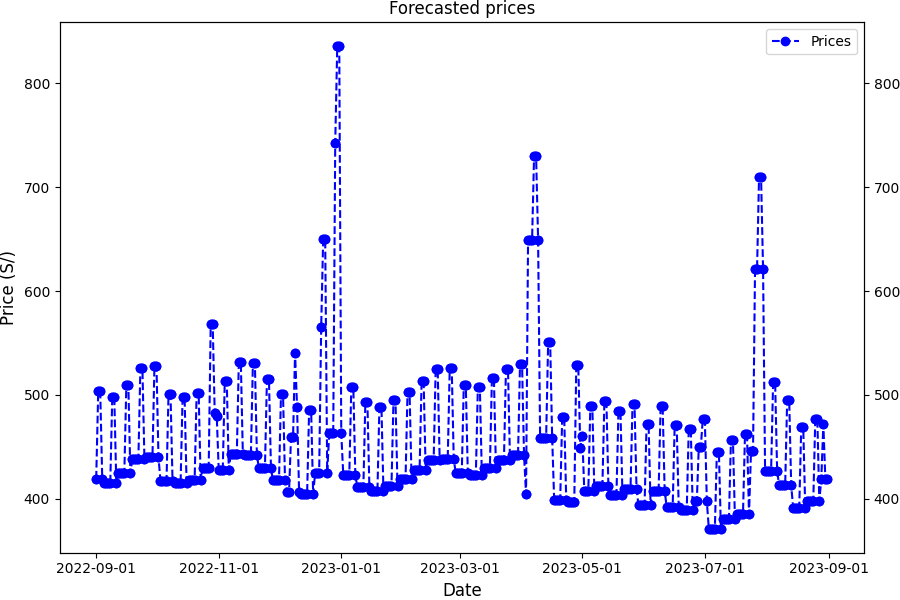

In [20]:
# Drop values too far into the future
df = df.drop(df[df.Date > '2023-09'].index)

print(df.head())
import matplotlib.dates as mdates

# We plot
fig, ax = plt.subplots(figsize=(9, 6))

fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

ax.scatter(df['Date'], df['Price'], color="blue", label="Prices")
ax2=ax.twinx()
ax2.plot(df['Date'], df['Price'], '--o', color="blue", label="Prices")

ax.set_xlabel("Date", fontsize = 12)
ax.set_ylabel("Price (S/)", color="black", fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Forecasted prices', fontsize = 12)
plt.legend()
plt.tight_layout(pad=0, w_pad=0.5, h_pad=1.0)

mplcursors.cursor(ax,hover=True) # Interacive

plt.show()

In [21]:
for index, row in df.iterrows():   
    print(row.Date.strftime('%Y-%m-%d'), " ", round(row.Price))

2022-09-01   419
2022-09-02   503
2022-09-03   503
2022-09-04   419
2022-09-05   415
2022-09-06   415
2022-09-07   415
2022-09-08   415
2022-09-09   498
2022-09-10   498
2022-09-11   415
2022-09-12   425
2022-09-13   425
2022-09-14   425
2022-09-15   425
2022-09-16   509
2022-09-17   509
2022-09-18   425
2022-09-19   439
2022-09-20   439
2022-09-21   439
2022-09-22   439
2022-09-23   526
2022-09-24   526
2022-09-25   439
2022-09-26   440
2022-09-27   440
2022-09-28   440
2022-09-29   440
2022-09-30   528
2022-10-01   528
2022-10-02   440
2022-10-03   417
2022-10-04   417
2022-10-05   417
2022-10-06   417
2022-10-07   501
2022-10-08   501
2022-10-09   417
2022-10-10   415
2022-10-11   415
2022-10-12   415
2022-10-13   415
2022-10-14   498
2022-10-15   498
2022-10-16   415
2022-10-17   418
2022-10-18   418
2022-10-19   418
2022-10-20   418
2022-10-21   502
2022-10-22   502
2022-10-23   418
2022-10-24   430
2022-10-25   430
2022-10-26   430
2022-10-27   430
2022-10-28   568
2022-10-29   5

In [22]:
df.to_csv('Pachacamac_prices.txt', columns=['Date','Price'], header=False, index=False, sep=' ', mode='w', float_format='%0.d')